In [138]:
## Analysis scripts for 2P-XNH-sister manuscript

In [3]:
## imports
%run /path_to_sister_2p_xnh_repo/scripts/startup.py

## Selected plots

In [5]:
## settings
sampleList = ['C432', 'Y391', 'Y489']
sampRate = 10 # Hz
start_s = 0
end_s = 5

r_all = {'C432': [1, 2], 'Y391': [1, 2, 3, 4], 'Y489': [1, 2, 3, 4]}
r_splits = {'C432': [[1], [2]], 'Y391': [[1, 3], [2, 4]], 'Y489': [[1, 3], [2, 4]]}


### 1. Reponse integral

In [6]:
## get response integral, cells sorted or unsorted
sisType = 'sisD2' # all cells
Zintavg_dict = {}
Zintavg_n_dict = {}
Zintavg_n_shuffle_dict = {}

for k in sampleList:
    dztrim = Ztrim_cell[k]
    sisD = sisD_all[k][sisType]
    cList = sisD['cell_list']
    
    # get Zintavg, normalized
    _, Zintavg_dict[k] = get_Fint_startEnd_selectedRepeats(dztrim, cList, moPairs[k], sampRate, start_s, end_s, repeatNames = r_all[k])
    Zintavg_n_dict[k] = get_Fintavg_norm(Zintavg_dict[k], normMethod = 'byColStd', returnType = 'dict')

    # get Zintavg, random cell order
    random.seed(1)
    cShuffle = deepcopy(cList)
    random.shuffle(cShuffle)
    Zintavg_n_shuffle_dict[k] = {i:Zintavg_n_dict[k][i] for i in cShuffle}


#### plot response matrix heatmap

In [7]:
## plot settings
fontsize_tick1 = 10
figW_base = 0.08
figH_base = 0.08
aspect = 1
lw = 0.8
dpi = 100
cmap_respM = 'PuOr_r'

# colour bar range
dmin = []
dmax = []
for k in sampleList:
    dmin.append(pd.DataFrame(Zintavg_n_dict[k]).min().min())
    dmax.append(pd.DataFrame(Zintavg_n_dict[k]).max().max())
dmin = np.min(dmin)
dmax = np.max(dmax)
dmax_abs = np.max(np.abs([dmax, dmin]))
normalize = colors.TwoSlopeNorm(vmin=-dmax_abs, vcenter=0., vmax=dmax_abs)

# x ticks labels
xtIdx = {}
xtIdx['C432'] = [0, 3, 19]
xtIdx['Y391'] = [0, 5, 7, 15, 21]
xtIdx['Y489'] = [0, 7, 10, 15, 20, 28, 40]


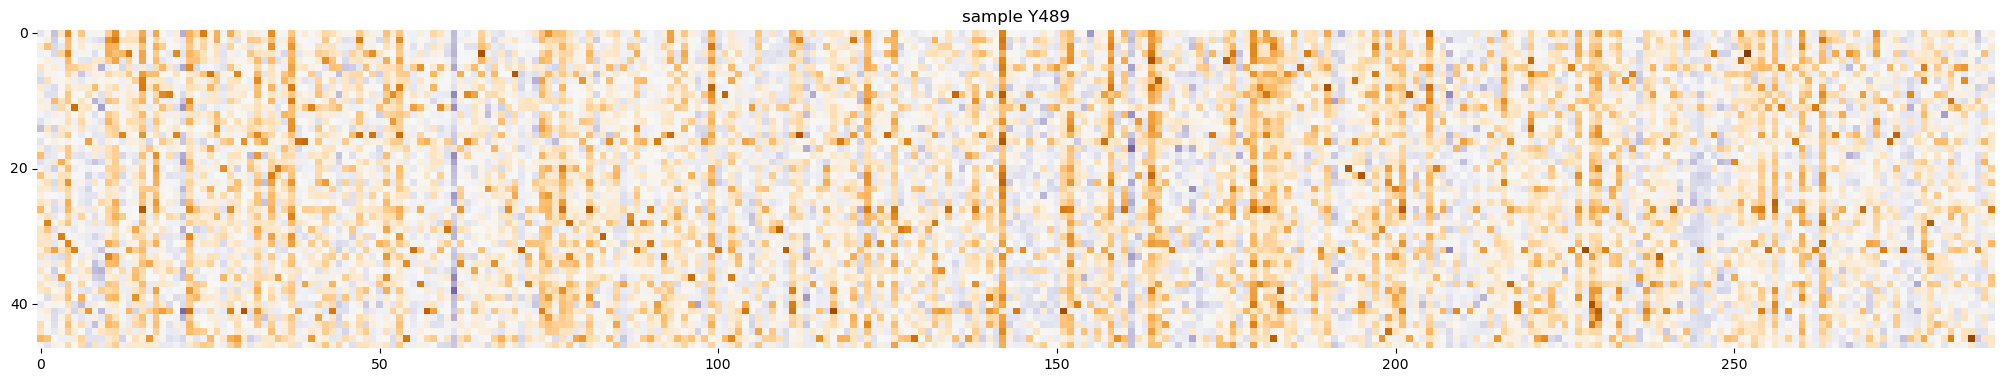

In [8]:
## plot unsorted response matrix, row = odour, column = cell
for k in ['Y489']:
    ddf = pd.DataFrame(Zintavg_n_shuffle_dict[k])
    # all ticks
    xt1 = np.arange(ddf.shape[1]) + 0.5
    xl1 = np.arange(ddf.shape[1]) #+ 1
    yt1 = np.arange(ddf.shape[0]) + 0.5
    yl1 = np.arange(ddf.shape[0]) #+ 1

    # sparse ticks
    xspacing = 50 # int(np.ceil(len(xt1) / 10))
    xt2 = xt1[::xspacing]
    xl2 = xl1[::xspacing]
    yspacing = 20
    yt2 = yt1[::yspacing]
    yl2 = yl1[::yspacing]
    
    figW = figW_base * ddf.shape[1]
    figH = figH_base * ddf.shape[0]
    f = plt.figure(figsize = (figW, figH), dpi = dpi)
    dmax = ddf.max().max()
    dmin = ddf.min().min()
    dmax_abs = np.max(np.abs([dmax, dmin]))
    normalize = colors.TwoSlopeNorm(vmin=-dmax_abs, vcenter=0., vmax=dmax_abs)
    sns.heatmap(ddf, cmap = cmap_respM, norm = normalize, cbar = False) #cbar_kws={"shrink": cbarShrink}

    ax = plt.gca()
    ax.set_aspect(aspect)
    plt.xticks(xt2, labels = xl2, fontsize = fontsize_tick1, rotation = 0)
    plt.yticks(yt2, labels = yl2, fontsize = fontsize_tick1)
    plt.tight_layout()
    plt.title(f'sample {k}')

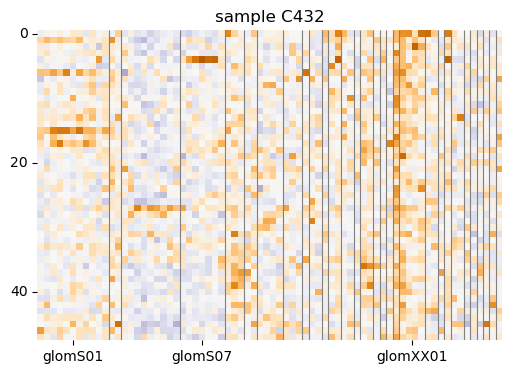

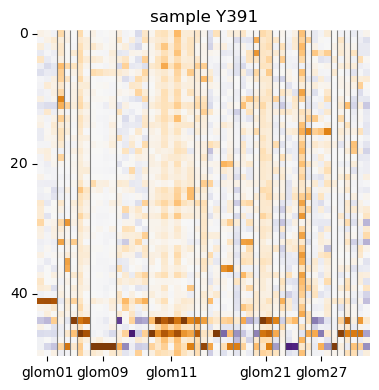

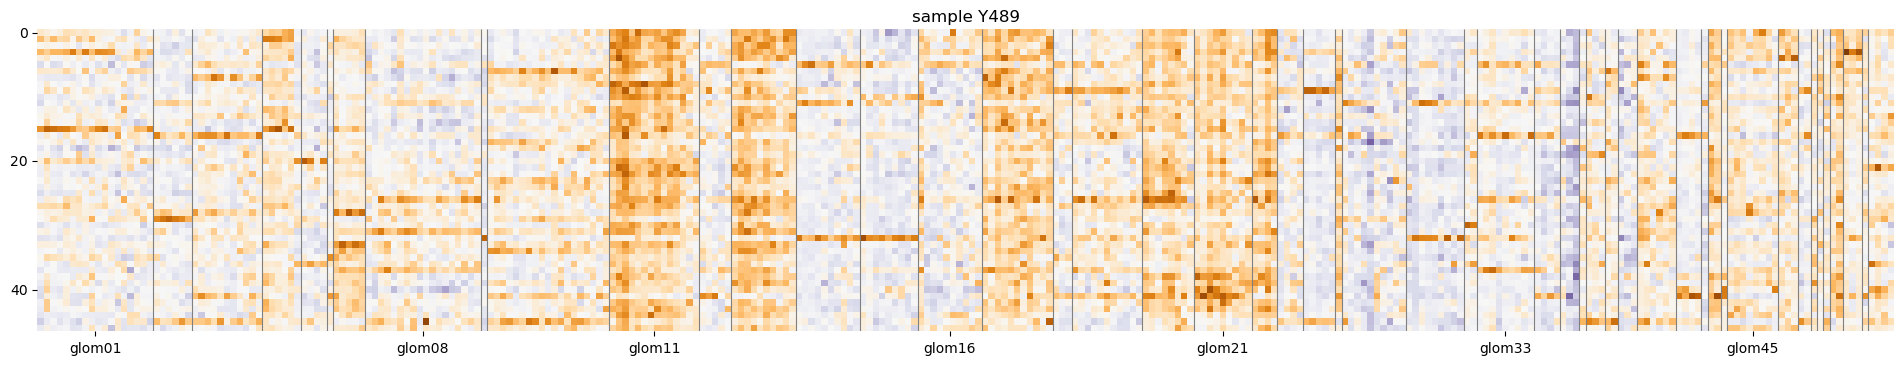

In [9]:
## plot response matrix, cells sorted by glom ID
for k in sampleList:
    # subset data
    ddf = pd.DataFrame(Zintavg_n_dict[k])
    sisD = sisD_all[k][sisType]

    # axis settings
    vlines = sisD['sister_n_cumsum'][:-1]
    xt1 = sisD['sister_n_cumsum'] - sisD['sister_n']/2
    xl1 = sisD['glom_uniq']
    xt2 = [xt1[i] for i in xtIdx[k]]
    xl2 = [xl1[i] for i in xtIdx[k]]

    yt1 = np.arange(ddf.shape[0]) + 0.5
    yl1 = np.arange(ddf.shape[0]) #+ 1
    yspacing = 20
    yt2 = yt1[::yspacing]
    yl2 = yl1[::yspacing]

    # plot
    figW = figW_base * ddf.shape[1]
    figH = figH_base * ddf.shape[0]
    f = plt.figure(figsize = (figW, figH), dpi = dpi)
    sns.heatmap(ddf, cmap = cmap_respM, norm = normalize, cbar = False) # cbar = False # cbar_kws={"shrink": cbarShrink}
    
    ax = plt.gca()
    ax.vlines(vlines, ymin = 0, ymax = ddf.shape[0], linestyle = '-', color = 'grey', linewidth = lw)
    ax.set_aspect(aspect)
    plt.xticks(xt2, xl2, fontsize = fontsize_tick1, rotation = 0) # rotation = 45
    plt.yticks(yt2, yl2, fontsize = fontsize_tick1)
    plt.title(f'sample {k}')
    plt.tight_layout()


### 2. Tuning correlation

#### plot correlation matrix heatmap

In [10]:
## get tuning correlation matrix
sisType = 'sisD2' # all cells
corrM_dict = {}
for k in sampleList:
    dztrim = Ztrim_cell[k]
    sisD = sisD_all[k][sisType]
    cList = sisD['cell_list']
    
    # get Zintavg split repeats
    _, Zintavg_13 = get_Fint_startEnd_selectedRepeats(dztrim, cList, moPairs[k], sampRate, start_s, end_s, repeatNames = r_splits[k][0])
    _, Zintavg_24 = get_Fint_startEnd_selectedRepeats(dztrim, cList, moPairs[k], sampRate, start_s, end_s, repeatNames = r_splits[k][1])

    # get correlation matrix
    corrM_dict[k] = get_corrM(pd.DataFrame(Zintavg_13), pd.DataFrame(Zintavg_24))


In [11]:
## plot settings
fontsize_tick = 12
figW = 4
figH = 4
aspect = 1
lw = 0.5
dpi = 100
cmap_corrM = get_saved_cmap('corrM_teal_pink')
normalize = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)


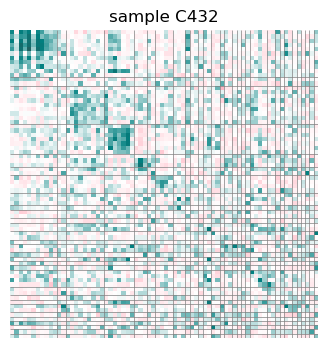

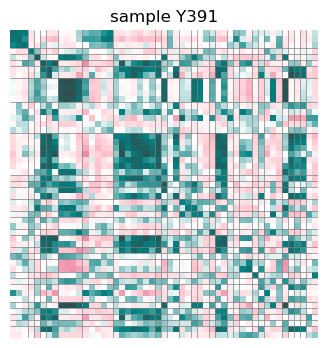

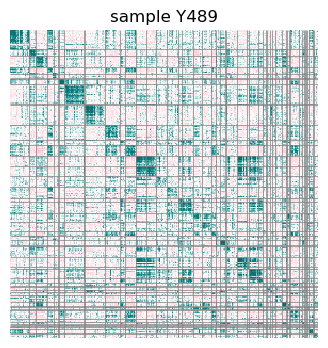

In [12]:
# plot corrM
for k in sampleList:
    # subset data
    corrM = corrM_dict[k]
    sisD = sisD_all[k][sisType]

    cN = len(sisD['cell_list'])
    hvline = sisD['sister_n_cumsum'][:-1]
    xt = sisD['sister_n_cumsum'] - sisD['sister_n']/2
    xl = np.arange(len(sisD['glom_uniq']))

    # plot the correlation matrix
    f = plt.figure(figsize= (figW, figH), dpi = dpi)
    normalize = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
    sns.heatmap(corrM, cmap = cmap_corrM, norm = normalize, cbar = None) #cbar_kws={"shrink": cbarShrink}

    # add sis division lines
    plt.hlines(y = hvline, xmin = 0, xmax = cN, linestyle = '-', color = 'grey', linewidth = lw)
    plt.vlines(x = hvline, ymin = 0, ymax = cN, linestyle = '-', color = 'grey', linewidth = lw)

    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'sample {k}')
    
    

#### plot correlation matrix boxplot

In [20]:
## get self, sis, non-sis correlation
sisType = 'sisD3r' # glom with >=2 sister cells

corrDict = {}
avgCorrDict = {}
pDict = {}

ztype = 'Zglobal' # in main
if ztype == 'Zglobal':
    dZ_cell = Zglobal_cell
    end_s = 10
elif ztype == 'Ztrim': # in SI
    dZ_cell = Ztrim_cell
    end_s = 5

# for each sample
for k in sampleList:
    dz = dZ_cell[k]
    dmo = moPairs[k]
    dr = r_splits[k]
    sisD = sisD_all[k][sisType]
    cList = sisD['cell_list']

    # get Zintavg split repeats
    _, Zintavg_13 = get_Fint_startEnd_selectedRepeats(dz, cList, dmo, sampRate, start_s, end_s, repeatNames = dr[0])
    _, Zintavg_24 = get_Fint_startEnd_selectedRepeats(dz, cList, dmo, sampRate, start_s, end_s, repeatNames = dr[1])

    # get correlation matrix
    corrM = get_corrM(pd.DataFrame(Zintavg_13), pd.DataFrame(Zintavg_24))

    # get corr for self, sister & stranger pairs
    corrDict[k] = get_corrM_subset_self_sis_stranger(corrM, sisD)

    # get avgCorr for self, sister & stranger
    avgCorrDict[k] = get_avgCorr_self_sis_stranger_perCell(corrM, sisD)

    # t-test
    _, p1 = stats.ttest_ind(avgCorrDict[k]['self'], avgCorrDict[k]['sister'], alternative = 'greater')
    _, p2 = stats.ttest_ind(avgCorrDict[k]['sister'], avgCorrDict[k]['stranger'], alternative = 'greater')
    _, p3 = stats.ttest_ind(avgCorrDict[k]['self'], avgCorrDict[k]['stranger'], alternative = 'greater')
    pDict[k] = [p1, p2, p3]


In [18]:
## plot settings
figW = 4
figH = 2
dpi = 100
lw = 1.5
dotAlpha = 0.5
cbase = ['#C0C0C0', '#808080', '#000000'] # slver, grey, black
cvec = cbase * 3

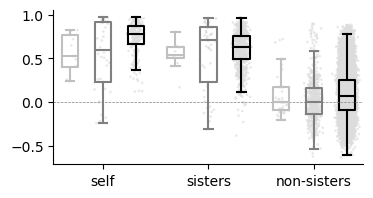

In [21]:
## plot all 3 samples, self, sister, stranger, scatter with box
yType = 'corrBox'
if yType == 'avgCorrBox':
    dy = avgCorrDict
elif yType == 'corrBox':
    dy = corrDict

xloc = [0, 1, 2, 3.2, 4.2, 5.2, 6.4, 7.4, 8.4]
xmin = xloc[0]-0.5
xmax = xloc[-1]+0.5

# plot
plt.figure(figsize = (figW, figH), dpi = dpi)
idx = 0
np.random.seed(0)
for k in ['self', 'sister', 'stranger']:
    for s in ['C432', 'Y391', 'Y489']:
        y = dy[s][k]
        jittered_x = np.random.normal(xloc[idx], 0.1, size=len(y))
        s = np.ones(len(y))
        
        # plot scatter
        plt.scatter(jittered_x, y, s, color = 'gainsboro', alpha = dotAlpha)
    
        # plot box
        plt.boxplot(y, positions = [xloc[idx]], widths = 0.5,
                    boxprops = {'color': cvec[idx], 'linewidth': lw},
                    whiskerprops = {'color': cvec[idx], 'linewidth': lw},
                    capprops={'color': cvec[idx], 'linewidth': lw},
                    medianprops={'color': cvec[idx], 'linewidth': lw},
                    flierprops = {'marker': 'o', 'markersize': 0})
        idx = idx + 1

plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'grey', linestyles = '--', linewidth = 0.5)
plt.xlim([xmin, xmax])
plt.xticks([xloc[1], xloc[4], xloc[7]], ['self', 'sisters', 'non-sisters'])
plt.yticks([-0.5, 0, 0.5, 1])

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


### 3. Reponse trace overlay

In [22]:
# example cell-odour pairs
k = 'Y489'

g3 = 'glom03' # very good polarity example
c3 = ['cell_plane5_272', 'cell_plane4_244']
osim3 = ['modd08_odour4'] # idx 41
odif3 = ['modd06_odour1'] # idx 26

g13 = 'glom13' # good shape example
c13 = ['cell_plane4_164', 'cell_plane5_97']
osim13 = ['modd01_odour5'] # idx 4
odif13 = ['modd07_odour4'] # idx 35

g33 = 'glom33' # good shape example
c33 = ['cell_plane5_314', 'cell_plane4_243']
osim33 = ['modd06_odour1'] # idx 26
odif33 = ['modd07_odour1'] # idx 32

gAll = [g3, g13, g33]
cAll = [c3, c13, c33]
osimAll = [osim3, osim13, osim33]
odifAll = [odif3, odif13, odif33]

# time axis
x40 = get_trial_x_s(info[k])
x40_ss10 = get_trial_x_trunc_subsample(x40, 0, 40, info['Y489']['resampleRate_Hz'], sampRate)

# repeat-averaged trace
Zavg_cell = {}
Zavg_cell[k] = get_Favg(Ztrim_cell[k], info[k]['cell_list'], moPairs['Y489'])


#### plot sister cell raw trace overlay

In [23]:
## plot settings
start_s = -2
end_s = 10
barSize = 5
figW = 1.5
figH = 1
cvec = ['olivedrab', 'teal']
dpi = 100


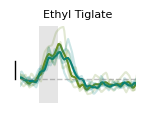

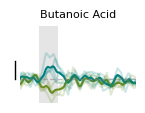

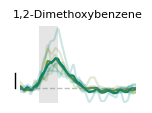

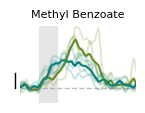

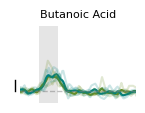

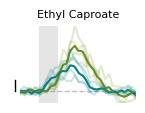

In [24]:
## plot cell-odour pair, all repeats
for idx, g in enumerate(gAll):
    c1 = cAll[idx][0]
    c2 = cAll[idx][1]
    osim = osimAll[idx][0]
    odif = odifAll[idx][0]
    dmin, dmax = get_Ftrim_subset_min_max(Ztrim_cell[k], [c1, c2], [osim, odif], [1, 2, 3, 4], sr10, start_s+3, end_s+3)
    
    for o in [osim, odif]:
        plt.figure(figsize = (figW, figH), dpi = dpi)
        # plot Zavg
        plt.plot(x40_ss10, Zavg_cell[k][c1][o], color = cvec[0])
        plt.plot(x40_ss10, Zavg_cell[k][c2][o], color = cvec[1])
        
        # plot Ztrim
        plt.plot(np.tile(x40_ss10, (4,1)).T, Ztrim_cell[k][c1][o].T, color = cvec[0] , alpha = 0.2)
        plt.plot(np.tile(x40_ss10, (4,1)).T, Ztrim_cell[k][c2][o].T, color = cvec[1] , alpha = 0.2)
        
        plot_outlook_odoPatch(0, 2, dmin-0.2, dmax+0.2)
        plt.xlim([start_s, end_s])
        plt.ylim([dmin-0.2, dmax+0.2])
        plt.xticks([])
        plot_outlook_boxOff('topRightBottom')
        plot_outlook_scalebarY(0, barSize, -2.5, 1)
        plt.hlines(y = 0, xmin = -2, xmax = 10, color = 'grey', linestyle = '--', linewidth = 1, alpha = 0.5)
        plt.title(f'{info[k]["modd_odo_map"][o]}', fontsize = 8)
        